In [1]:
import sympy as sy
time, x, xdot, delta = sy.symbols('t x_1 x_2 \\delta')

from sympy import latex
from IPython.display import display_latex

def disp(idx, symObj):
    eqn = '\\[' + idx + ' ' + latex(symObj) + '\\]'
    display_latex(eqn,raw=True)
    return

from IPython.display import display_latex
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, least_squares

import ssmlearnpy.reduced_dynamics.normalform as normalform
from ssmlearnpy.utils import ridge
from ssmlearnpy.reduced_dynamics.shift_or_differentiate import shift_or_differentiate
from scipy.io import savemat, loadmat

import logging
logger = logging.getLogger("ridge_regression")
logger.setLevel(logging.WARNING)

In [2]:
deltaa = 0.0
ga = 0.1
om = 2*np.pi*1.0

In [3]:
def vectorfield(t,x):
    return np.array([x[1], x[0]-x[0]**3 - deltaa*x[1] - ga*np.cos(om*t)])

In [4]:
t = np.linspace(0, 100, 1001)
dt = t[1] - t[0]

In [5]:
# Initial conditions
ic_0 = np.array([0.1, 0])
ic_1 = np.array([0.32, .1])

In [6]:
# Numerical solutions
sol_0 = solve_ivp(vectorfield, [t[0], t[-1]], ic_0, t_eval=t)
sol_1 = solve_ivp(vectorfield, [t[0], t[-1]], ic_1, t_eval=t)

In [7]:
sol_0

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-01 ...  9.990e+01  1.000e+02]
        y: [[ 1.000e-01  1.000e-01 ... -1.410e+00 -1.392e+00]
            [ 0.000e+00  5.426e-04 ...  1.235e-01  2.495e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1352
     njev: 0
      nlu: 0

In [8]:
sol_0.y

array([[ 1.00000000e-01,  1.00010733e-01,  1.00230576e-01, ...,
        -1.41590556e+00, -1.41027811e+00, -1.39153744e+00],
       [ 0.00000000e+00,  5.42606982e-04,  4.67321327e-03, ...,
        -1.21909053e-02,  1.23458530e-01,  2.49469974e-01]])

In [9]:
sol_0.y[:,0]

array([0.1, 0. ])

In [10]:
sol_1.y[:,0]

array([0.32, 0.1 ])

In [11]:
# Reshape solutions into array "trajectories"
trajectories = [sol_0.y - np.array([1,0]).reshape(-1,1), sol_1.y - np.array([1,0]).reshape(-1,1)]
# Array containing time spawn
times = [t, t]

### Plot data

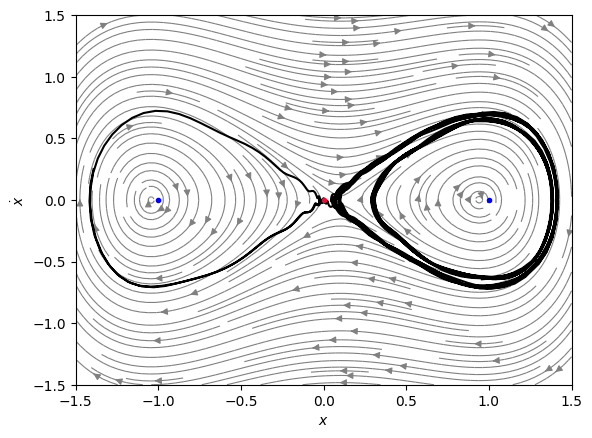

In [12]:
xx = np.linspace(-1.5, 1.5, 30)
yy = np.linspace(-1.5, 1.5, 30)
Xmesh, Ymesh = np.meshgrid(xx, yy)
grid = np.vstack((Xmesh.ravel(), Ymesh.ravel()))
U, V = vectorfield(0, grid)
U = U.reshape(Xmesh.shape)
V = V.reshape(Xmesh.shape)

plt.streamplot(Xmesh, Ymesh, U, V, color='grey', linewidth = 0.8, density = 2)
plt.xlabel('$x$')
plt.ylabel('$\\dot{x}$')

for t in trajectories:
    plt.plot(t[0,:]+1, t[1,:], '-', c='black')
plt.plot(0,0, '.', c='crimson')
plt.plot(1,0, '.', c='blue')
plt.plot(-1,0, '.', c='blue')

### Fit using SSMLearn

In [13]:
# Order
polyDeg = 3
# Degrees of freedom
ndofs = 1

In [14]:
X, y  = shift_or_differentiate(trajectories, times, 'flow') 

In [15]:
# The _ array contains the trajectories
X == trajectories

True

In [16]:
# The y array contains d./dt of the trajectories
y

[array([[ 3.31307519e-04,  1.10921817e-03,  4.74009328e-03, ...,
         -1.21931183e-02,  1.24000329e-01,  2.48784917e-01],
        [ 3.10580934e-04,  1.86798211e-02,  6.85385254e-02, ...,
          1.38722479e+00,  1.30548244e+00,  1.19851973e+00]]),
 array([[ 0.10116683,  0.11964405,  0.14396708, ..., -0.61960858,
         -0.63795099, -0.64451201],
        [ 0.18589134,  0.21418953,  0.27406049, ..., -0.22082258,
         -0.12480997, -0.01816752]])]

In [17]:
# A priori knowledge
# Add the constraints to the fixed points explicitly
constLHS = [[-1, 0]]
constRHS = [[0, 0]]
cons = [constLHS, constRHS]
# Such that model.prediction(LHS) = RHS

In [18]:
# Fit a ridge regression model to the data
mdl = ridge.get_fit_ridge(X, y, poly_degree = polyDeg, constraints = cons)

In [19]:
# Check that the constraints are enforced
print(mdl.predict(constLHS), constRHS)

[[2.58139898e-13 4.78005413e-11]] [[0, 0]]


In [20]:
# Get an estimate of the linear part
linearPart = mdl.map_info['coefficients'][:,:2]

In [21]:
"""Minimize
    ||d\dt (y + f_normalform(y)) - \Lambda*(y+f_normalform(y)) - N_normalform(y+f_normalform)||^2
    where \Lambda is the linear part of the dynamics and N_normalform is the nonlinear part of the normal form dynamics
    f_normalform is the nonlinear part of the normal form transformation z = T^{-1}(y) = y + f_normalform(y).
    """
nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv \
    = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = polyDeg)

In [22]:
"""We do a ridge regression on the diagonalized coordinates (modal coordinates). 
    The initial condition for the optimization is taken as the modal dynamics ridge regression problem. 
    """
initial_guess = normalform.create_normalform_initial_guess(mdl, nf)

In [23]:
# Solve the objective function with the initial guess
np.random.seed(3)
res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')

In [24]:
# Unpack the optimized coefficients into a dictionary
d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)

Linear part for $\delta = 0.1$,

$$
\lambda = −0.05\pm1.41332940251026𝑖
$$

In [25]:
# Estimated linear part
print(nf.LinearPart[1,1])

(0.007364757477431712-1.4117389086571603j)


In [26]:
# Wrap the optimized coefficients into a NonlinearCoordinateTransform object
trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, polyDeg, d )

In [27]:
dyn

{'coefficients': array([[ 0.00736476 +1.41173891j,  0.         +0.j        ,
          0.         +0.j        ,  0.         +0.j        ,
          0.         +0.j        ,  0.         +0.j        ,
         -0.47049582-16.5250333j ,  0.         +0.j        ,
          0.         +0.j        ]]),
 'exponents': array([[1, 0, 2, 1, 0, 3, 2, 1, 0],
        [0, 1, 0, 1, 2, 0, 1, 2, 3]]),
 'vectorfield': <function ssmlearnpy.reduced_dynamics.normalform.wrap_optimized_coefficients.<locals>.vectorfield(t, x)>}

In [28]:
trajectories[0].shape

(2, 1001)

Text(0.5, 1.0, 'Exact trajectories')

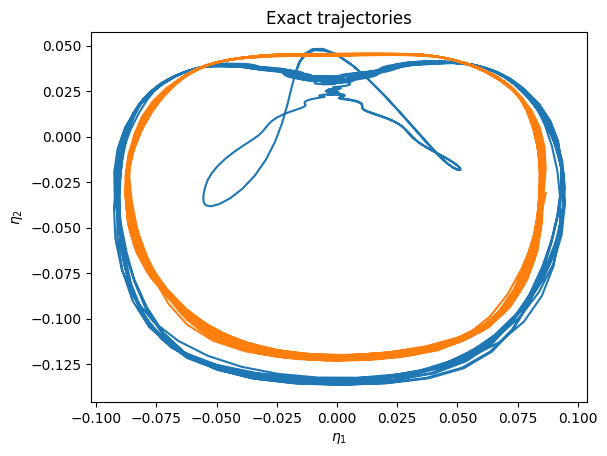

In [29]:
# Plot the trajectories in the normal form coordinates
for t in trajectories:
    transformed = trf.inverse_transform(t) 
    plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]))
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.title('Exact trajectories')

In [30]:
trf

In [31]:
time_pred = np.linspace(0, 100, 1001)

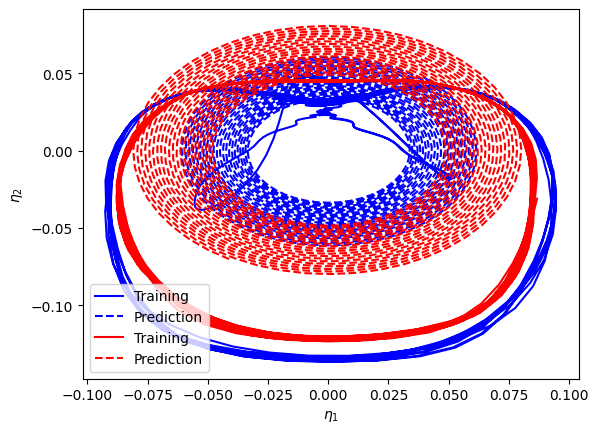

In [32]:
clit=1
for t in trajectories:
    if clit==1:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='blue', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='blue', label = 'Prediction')
        clit+=1
    elif clit==2:
        transformed = trf.inverse_transform(t)
        plt.plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='red', label = 'Training')
        ic = transformed[:,0]
    
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        plt.plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='red', label = 'Prediction')
        clit+=1
plt.xlabel('$\\eta_1$')
plt.ylabel('$\\eta_2$')
plt.legend()

Order: 3, Residual: 2.0678649000962173 

Order: 5, Residual: 0.8215093466297615 



/home/tf/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=8.70873e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Order: 7, Residual: 0.08536477993636955 



ValueError: The normal form is not applicable. All eigenvalues need to be complex

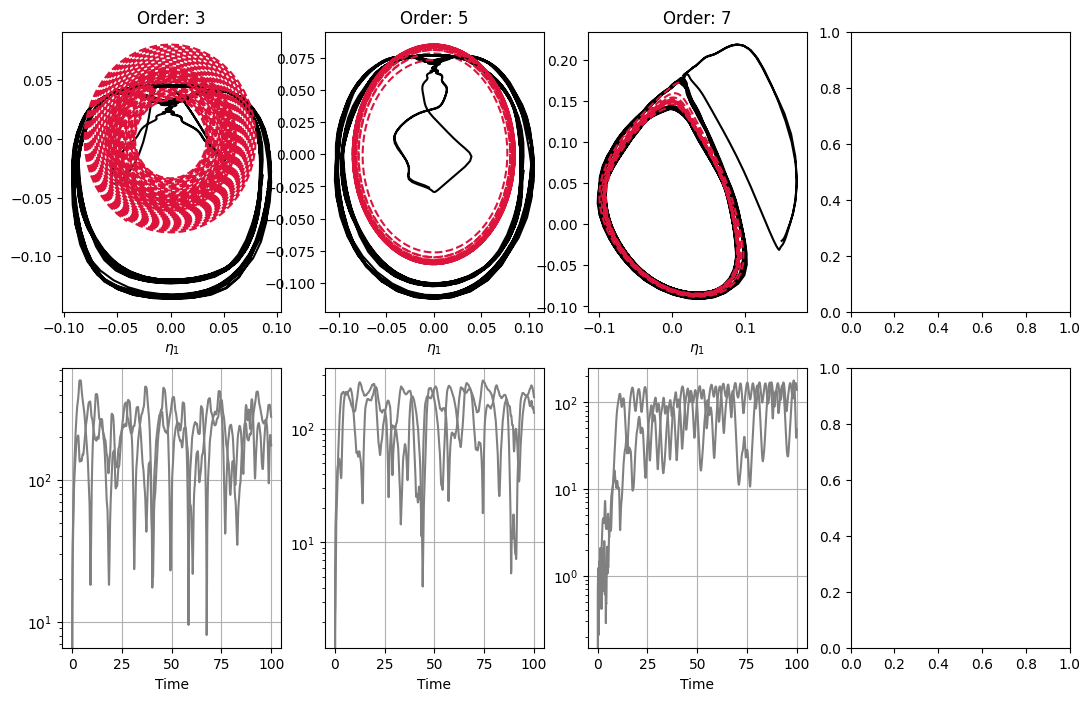

In [114]:
f,ax = plt.subplots(2,4,figsize = (13, 8))
orders = [3, 5, 7, 9]
n_orders = len(orders)
for i in range(n_orders):
    order = orders[i]
    mdl = ridge.get_fit_ridge(X, y, poly_degree = order, constraints = cons) # pre-fit with regular ridge regression
    linearPart = mdl.map_info['coefficients'][:,:2]

    nf, n_unknowns_dynamics, n_unknowns_transformation, objectiv = normalform.create_normalform_transform_objective(times, trajectories, linearPart, degree = order)
    initial_guess = normalform.create_normalform_initial_guess(mdl, nf)
    res = least_squares(objectiv, initial_guess, jac='2-point', method='lm')
    print('Order: %s, Residual: %s \n' %(order, res.cost))
    d = normalform.unpack_optimized_coeffs(res.x, ndofs, nf, n_unknowns_dynamics, n_unknowns_transformation)
    trf, dyn = normalform.wrap_optimized_coefficients(ndofs, nf, order, d )
    ax[0,i].set_xlabel('$\\eta_1$')
    ax[0,i].set_title('Order: %s' %order)
    for t in trajectories:
        transformed = trf.inverse_transform(t)
        ax[0,i].plot(np.real(transformed[0,:]), np.imag(transformed[0,:]), '-', c='black', label = 'Training')
        ic = transformed[:,0]
        pred = solve_ivp(dyn['vectorfield'], [time_pred[0], time_pred[-1]], ic, t_eval=time_pred, method = 'DOP853')
        ax[0,i].plot(np.real(pred.y[0,:]), np.imag(pred.y[0,:]), '--', c='Crimson', label = 'Prediction')
        ## we also compute the error along trajectories
        tonorm = np.max(np.abs(transformed[:,0]))
        error = np.abs(pred.y[0,:] - transformed[0,:])/tonorm
        ax[1,i].semilogy(pred.t, error*100, '-', c='grey', label ='Relative error')
            
    ax[1,i].grid()  
    ax[1,i].set_xlabel('Time')
ax[0,0].set_ylabel('$\\eta_2$')
ax[1,0].set_ylabel('Relative error [%]')